<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


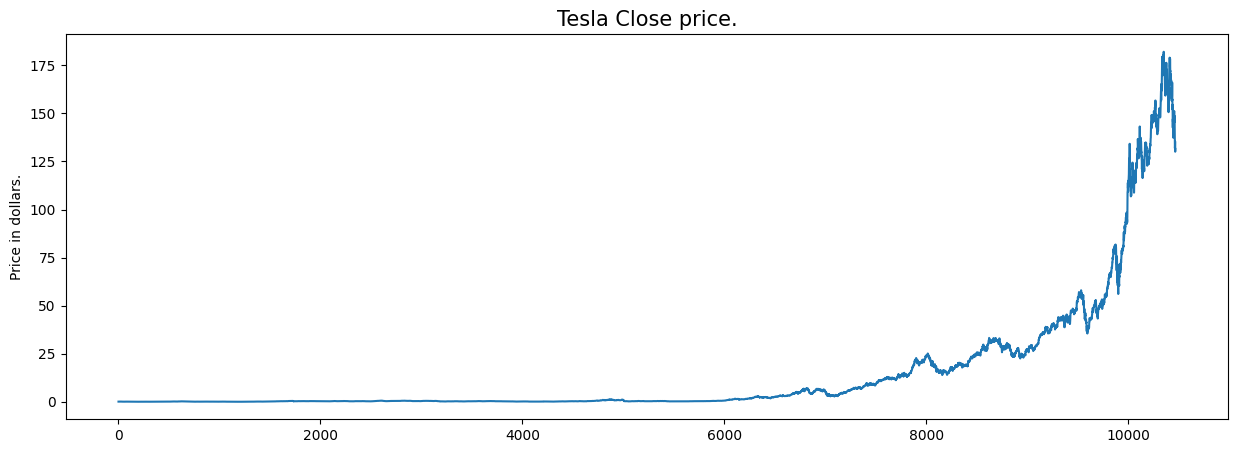

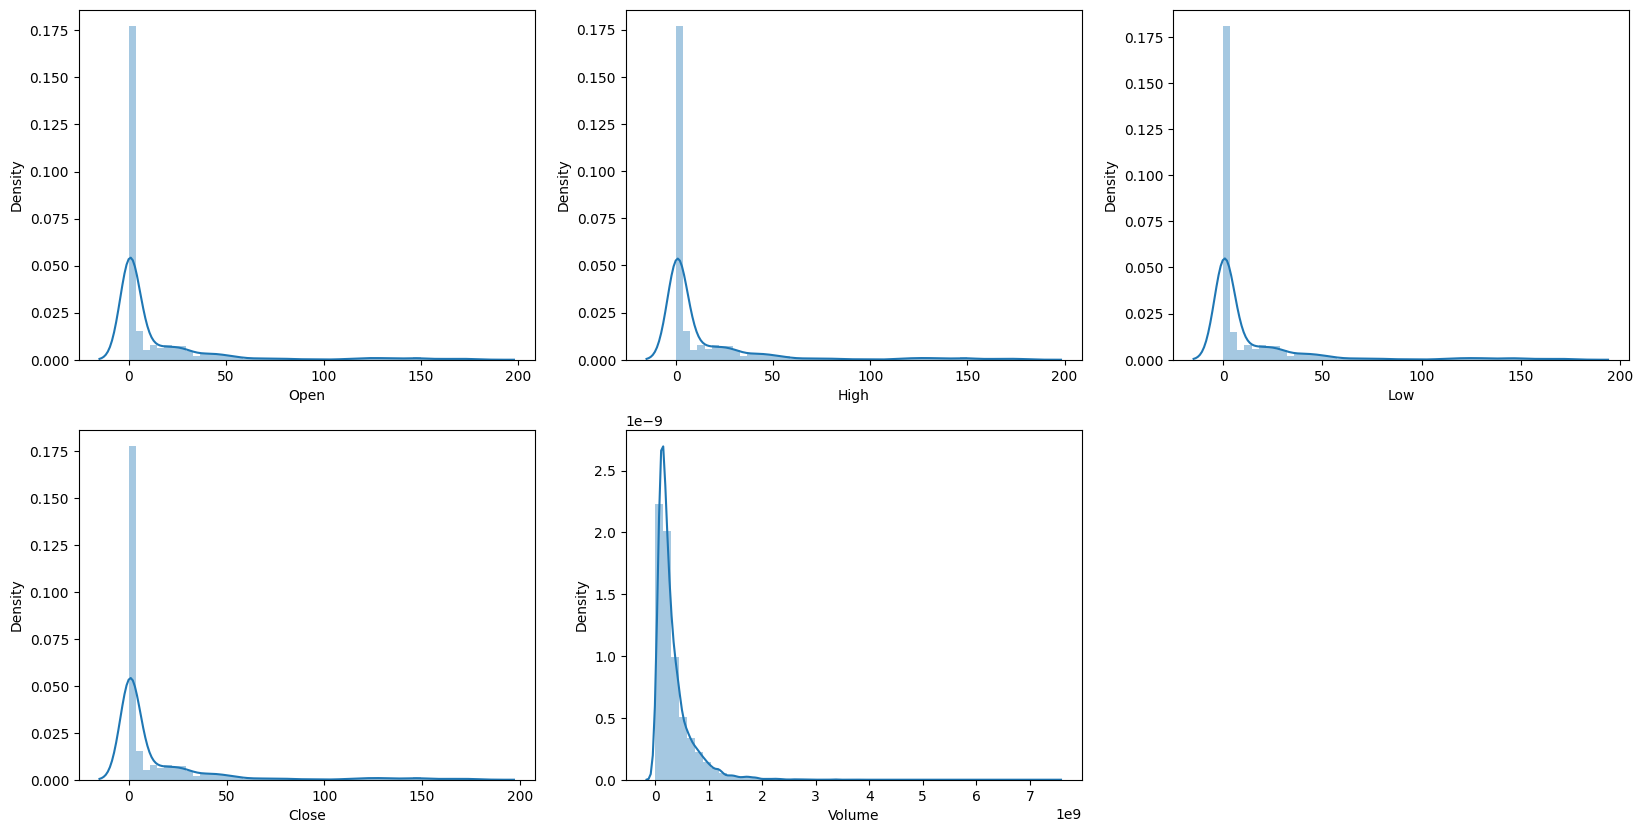

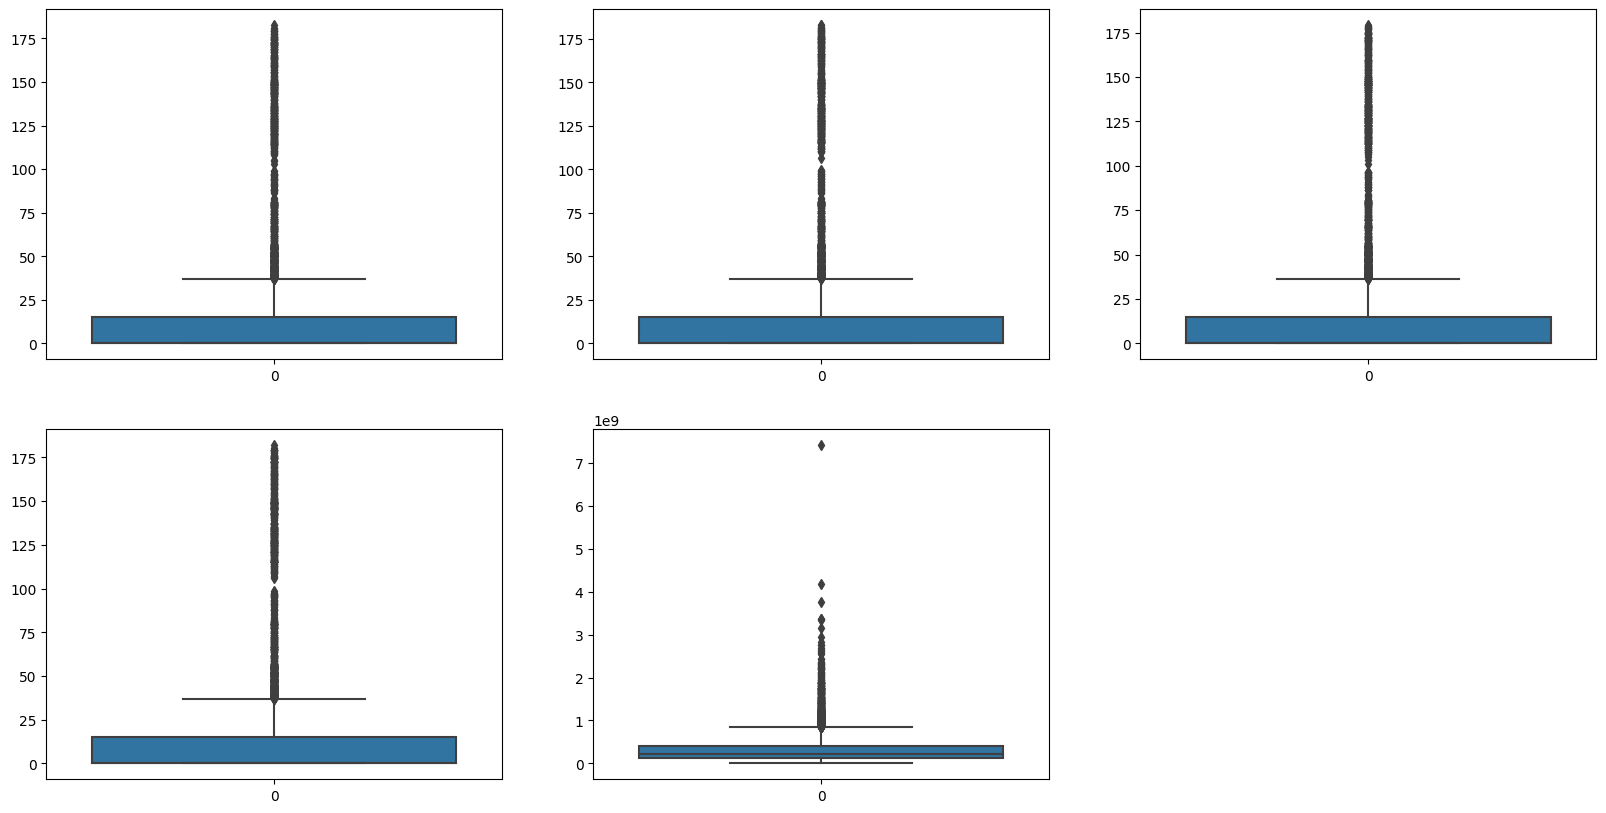

KeyError: 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
 
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('apple-stock-price.csv')
df.head()

df.shape

df.describe()

df.info()

# Exploratory Data Analysis
plt.figure(figsize=(15,5))
plt.plot(df['Close'])
plt.title('Tesla Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

df.head()

df[df['Close'] == df['Adj Close']].shape

df = df.drop(['Adj Close'], axis=1)

df.isnull().sum()


features = ['Open', 'High', 'Low', 'Close', 'Volume']
 
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.distplot(df[col])
plt.show()


plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,3,i+1)
  sb.boxplot(df[col])
plt.show()


# Feature Engineering
splitted = df['Date'].str.split('/', expand=True)
 
df['day'] = splitted[1].astype('int')
df['month'] = splitted[0].astype('int')
df['year'] = splitted[2].astype('int')
 
df.head()


df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()


data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
 
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

df.groupby('is_quarter_end').mean()


df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)


plt.pie(df['target'].value_counts().values,
        labels=[0, 1], autopct='%1.1f%%')
plt.show()


plt.figure(figsize=(10, 10))
 
# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()


# Data Splitting and Normalization
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']
 
scaler = StandardScaler()
features = scaler.fit_transform(features)
 
X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)


# Model Development and Evaluation
models = [LogisticRegression(), SVC(
  kernel='poly', probability=True), XGBClassifier()]
 
for i in range(3):
  models[i].fit(X_train, Y_train)
 
  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()


metrics.plot_confusion_matrix(models[0], X_valid, Y_valid)
plt.show()